In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --upgrade --quiet jupyter_client ipywidgets

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [6]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [7]:
cd "/root/SymmNeRF/"

/root/SymmNeRF


In [8]:
from opt import config_parser
import torch 

parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:1")
det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 1
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'
args.no_load_opt = True

In [6]:
print(lindisp)

False


## Enforcing Symmetry impact - Only the fine network is affected with this symmetry enforcement. 

In [7]:
from datasets import dataset_dict, create_training_dataset
from torch.utils.data import DataLoader 

from model import model_dict  
from model.sample_ray import RaySampler 
from model.render_ray import render_single_image

from utils_lab_fct import * 

import setproctitle
import torch 
import numpy as np 
import cv2
import glob 
import os
from einops import rearrange 
import matplotlib.pyplot as plt
import lpips
from skimage import metrics
import tqdm 

setproctitle.setproctitle('[Gaetan. - Test EnforceSymm.]')

# Folder directories. 
logs_folder = '/root/SymmNeRF/logs/srns_dataset/cars/'
ckpts_folder_symmnerf = os.path.join(logs_folder,'baseline/ckpts')
ckpts_folder_enforceSymm = os.path.join(logs_folder,'enforceSymmFineOnlyWithConcat/ckpts')

# LPIPS 
lpips_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth


#### Define the symmetry matrix M we used. 

In [9]:
M = torch.tensor([[-1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]).to(device)

#### Build up a batch. 

#### Load model weights.

In [10]:
args.enforce_symmetry = {'status': False, 'on_coarse': False,'on_fine': False,'concatenate_on_coarse':False, 'concatenate_on_fine':True}
model_ori = model_dict[args.model](args, ckpts_folder_symmnerf)

NameError: name 'model_dict' is not defined

In [ ]:
args.enforce_symmetry = {'status': True, 'on_coarse': False,'on_fine': True, 'concatenate_on_coarse':False, 'concatenate_on_fine':True}
model_enforceSymm = model_dict[args.model](args,ckpts_folder_enforceSymm)

#### Build up a data list to randomize the test set.

In [11]:
from utils_lab_fct import get_n_instance,get_an_instance_and_its_ray_sampler
bs = 1

test_dataset = dataset_dict[args.eval_dataset](args, 'test', scene=args.eval_scene)
test_loader = DataLoader(test_dataset, batch_size=bs)

SRNsDataset:  /data/datasets/srn_cars/cars_test


In [12]:
data_list = get_n_instance(test_loader,n=10)
data, ray_sampler,render_view,bs_idx = get_an_instance_and_its_ray_sampler(data_list)

In [16]:
model_ori.switch_to_eval()
model_enforceSymm.switch_to_eval()

with torch.no_grad():
       
        src_imgs = ray_sampler.src_img     # [B, 3, 128,128]
        tgt_imgs = ray_sampler.render_imgs # [B,NV,3,128,128]

        ray_batch = ray_sampler.get_all_single_image(render_view,device)
        
        latent_vector_ori = model_ori.encode(ray_batch)
        latent_vector_enforceSymm = model_enforceSymm.encode(ray_batch)
        
        ret_ori = render_single_image(ray_sampler=ray_sampler,
                                  ray_batch=ray_batch,
                                  model=model_ori,
                                  device=device,
                                  latent_vector=latent_vector_ori,
                                  chunk_size=args.chunk_size,
                                  N_samples=args.N_samples,
                                  M = M,
                                  enforceSymm = {'status': False, 'on_coarse': False,'on_fine': False,'concatenate_on_coarse':False, 'concatenate_on_fine':True},
                                  lindisp=args.lindisp,
                                  det=True,
                                  N_importance=args.N_importance,
                                  white_bkgd=args.white_bkgd,
                                  noise=None)
        
        ret_enforceSymm = render_single_image(ray_sampler=ray_sampler,
                                  ray_batch=ray_batch,
                                  model=model_enforceSymm,
                                  device=device,
                                  latent_vector=latent_vector_enforceSymm,
                                  chunk_size=args.chunk_size,
                                  N_samples=args.N_samples,
                                  M = M,
                                  enforceSymm ={'status': True, 'on_coarse': False,'on_fine': True, 'concatenate_on_coarse':False, 'concatenate_on_fine':True},
                                  lindisp=args.lindisp,
                                  det=True,
                                  N_importance=args.N_importance,
                                  white_bkgd=args.white_bkgd,
                                  noise=None)
        
        fine_pred_rgb = ret_ori['outputs_fine']['rgb'].detach()
        fine_pred_rgb_enforceSymm = ret_enforceSymm['outputs_fine']['rgb'].detach() # +ret_enforceSymm['outputs_fine_S']['rgb']).detach()/2.
        
        It_pred_original = np.clip(fine_pred_rgb.numpy(), a_min=0., a_max=1.)
        It_pred_enforceSymm = np.clip(fine_pred_rgb_enforceSymm.numpy(), a_min=0., a_max=1.)
        
        # Is image. 
        Is = np.clip(ray_batch['src_img'][0].permute(1, 2, 0).detach().cpu().numpy(), a_min=0, a_max=1.)
        
        # It image. 
        It = np.clip(ray_sampler.render_imgs[0][render_view].permute(1, 2, 0).detach().cpu().numpy(), a_min=0, a_max=1.)

psnr_original,ssim_original,lpips_original = compute_metrics(It_pred_original,It,lpips_vgg,device)
psnr_enforceSymm,ssim_enforceSymm,lpips_enforceSymm = compute_metrics(It_pred_enforceSymm,It,lpips_vgg,device)

Shape of latent: torch.Size([1, 512, 64, 64])
Shape of the latent_scaling factor: tensor([2.0317, 2.0317], device='cuda:1')
Shape of latent: torch.Size([1, 512, 64, 64])
Shape of the latent_scaling factor: tensor([2.0317, 2.0317], device='cuda:1')
Image size: tensor([128., 128.], device='cuda:1')
Value of the scale: tensor([0.0159, 0.0159], device='cuda:1')


NameError: name 'exit' is not defined

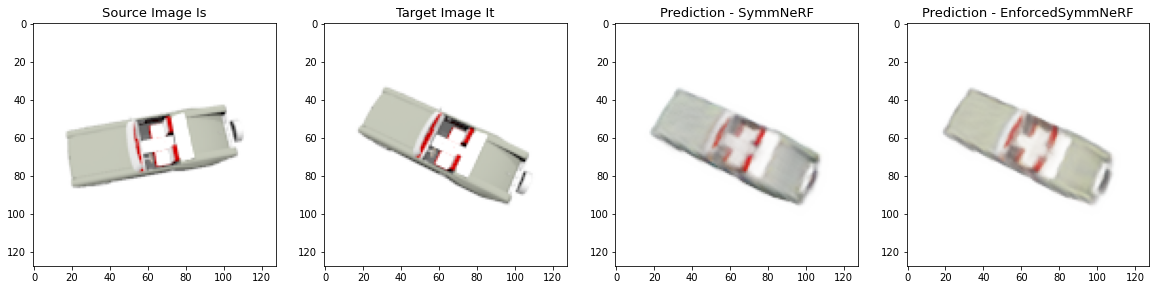


                                                psnr original: 26.41dB, psnr enforceSymm: 25.52dB
                                                ssim original: 0.947,    ssim enforceSymm: 0.937
                                                lpips original: 0.055,  lpips enforceSymm: 0.055


In [14]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(Is)
ax2.imshow(It)
ax3.imshow(It_pred_original)
ax4.imshow(It_pred_enforceSymm)

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)
ax3.set_title('Prediction - SymmNeRF', fontsize=13)
ax4.set_title('Prediction - EnforcedSymmNeRF', fontsize=13)

plt.show()


print(f'''
                                                =================================================
                                                psnr original: {psnr_original}dB, psnr enforceSymm: {psnr_enforceSymm}dB
                                                ssim original: {ssim_original:.3f},    ssim enforceSymm: {ssim_enforceSymm:.3f}
                                                lpips original: {lpips_original},  lpips enforceSymm: {lpips_enforceSymm}
                                                ==================================================''')

#### Failure Cases. 

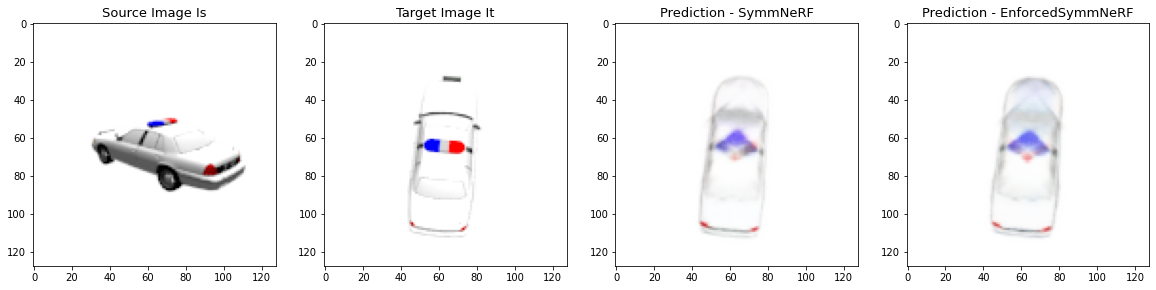


                                                psnr original: 24.52dB, psnr enforceSymm: 23.82dB
                                                ssim original: 0.916,    ssim enforceSymm: 0.902
                                                lpips original: 0.106,  lpips enforceSymm: 0.11


In [40]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(Is)
ax2.imshow(It)
ax3.imshow(It_pred_original)
ax4.imshow(It_pred_enforceSymm)

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)
ax3.set_title('Prediction - SymmNeRF', fontsize=13)
ax4.set_title('Prediction - EnforcedSymmNeRF', fontsize=13)

plt.show()


print(f'''
                                                =================================================
                                                psnr original: {psnr_original}dB, psnr enforceSymm: {psnr_enforceSymm}dB
                                                ssim original: {ssim_original:.3f},    ssim enforceSymm: {ssim_enforceSymm:.3f}
                                                lpips original: {lpips_original},  lpips enforceSymm: {lpips_enforceSymm}
                                                ==================================================''')

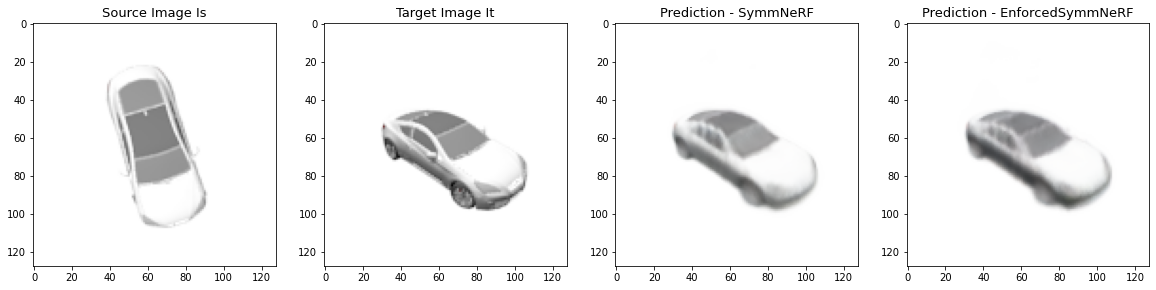


                                                psnr original: 27.79dB, psnr enforceSymm: 25.48dB
                                                ssim original: 0.956,    ssim enforceSymm: 0.941
                                                lpips original: 0.064,  lpips enforceSymm: 0.083


In [61]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(Is)
ax2.imshow(It)
ax3.imshow(It_pred_original)
ax4.imshow(It_pred_enforceSymm)

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)
ax3.set_title('Prediction - SymmNeRF', fontsize=13)
ax4.set_title('Prediction - EnforcedSymmNeRF', fontsize=13)

plt.show()


print(f'''
                                                =================================================
                                                psnr original: {psnr_original}dB, psnr enforceSymm: {psnr_enforceSymm}dB
                                                ssim original: {ssim_original:.3f},    ssim enforceSymm: {ssim_enforceSymm:.3f}
                                                lpips original: {lpips_original},  lpips enforceSymm: {lpips_enforceSymm}
                                                ==================================================''')

## Evaluation on the whole test set. 

In [11]:
bs = 1

test_dataset = dataset_dict[args.eval_dataset](args, 'test', scene=args.eval_scene)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

SRNsDataset:  /data/datasets/srn_cars/cars_test


In [12]:
from eval.assessment_eval import EvaluateWithMetrics

In [25]:
print(len(test_loader))

704


In [28]:
evalTest = EvaluateWithMetrics(modelA = model_ori,
                               modelB = model_enforceSymm,
                               symmetry = {'A' : {'status': False, 'on_coarse': False,'on_fine': False,'concatenate_on_coarse':False, 'concatenate_on_fine':True},
                                           'B' : {'status': True, 'on_coarse': False,'on_fine': True, 'concatenate_on_coarse':False, 'concatenate_on_fine':True}
                                          },
                               loader = test_loader,
                               Ray_Sampler = RaySampler,
                               Nsamples = 500,
                               out_dir = '/data/',
                               exp_name = 'FineSymmEnforcedWithConcat',
                               device = device)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth


In [29]:
evalTest.computeMetrics()

  0%|          | 0/500 [00:00<?, ?it/s]/root/SymmNeRF/eval/assessment_eval.py:40: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  res['ssim'] = metrics.structural_similarity(img_gt, img_pred, multichannel=True,data_range = 1)
100%|██████████| 500/500 [1:04:08<00:00,  7.70s/it]

Complete results: {'modelA': {'psnr': 22.88, 'ssim': 0.897, 'lpips': 0.104}, 'modelB': {'psnr': 22.51, 'ssim': 0.894, 'lpips': 0.104}}
